## IMPORTS

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import *
from qiskit.visualization import *
from qiskit.circuit.random import random_circuit
from qiskit import assemble, transpile
from torchsummary import summary

from itertools import combinations
DEVICE = torch.device('cpu')

## DATA

In [53]:
n_train = 20   
n_test = 50 

train_dataset = datasets.MNIST(root = "./data",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
idx = np.append(np.where(train_dataset.targets == 0)[0][:n_train], 
                np.where(train_dataset.targets == 1)[0][:n_train])

for i in range(2, 10):
    idx = np.append(idx, np.where(train_dataset.targets == i)[0][:n_train])
    
train_dataset.data    = train_dataset.data[idx]
train_dataset.targets = train_dataset.targets[idx]

test_dataset = datasets.MNIST(root = "./data",
                              train = False,
                              transform = transforms.ToTensor())

idx = np.append(np.where(test_dataset.targets == 0)[0][:n_test], 
                np.where(test_dataset.targets == 1)[0][:n_test])

for i in range(2, 10):
    idx = np.append(idx, np.where(test_dataset.targets == i)[0][:n_test])
    
test_dataset.data    = test_dataset.data[idx]
test_dataset.targets = test_dataset.targets[idx]

BATCH_SIZE = 5

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

## TRAINING FUNCTION

In [54]:
def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=10, device='cpu'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
              (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history


## CLASSICAL MODEL

In [55]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 1, kernel_size=2)
        self.conv2 = nn.Conv2d(1, 10, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(160, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)
model1 = Net()
optimizer  = optim.Adam(model1.parameters(), lr=0.001)
loss_fn  = nn.CrossEntropyLoss()

## TRAINING & PERFORMANCE

In [56]:
history1 = train(
    model = model1,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_dl = train_loader,
    val_dl = test_loader,
    epochs=20)

train() called: model=Net, opt=Adam(lr=0.001000), epochs=20, device=cpu

Epoch   1/ 20, train loss:  2.31, train acc:  0.09, val loss:  2.27, val acc:  0.10
Epoch   2/ 20, train loss:  2.25, train acc:  0.17, val loss:  2.19, val acc:  0.29
Epoch   3/ 20, train loss:  2.10, train acc:  0.37, val loss:  1.97, val acc:  0.47
Epoch   4/ 20, train loss:  1.83, train acc:  0.43, val loss:  1.60, val acc:  0.57
Epoch   5/ 20, train loss:  1.36, train acc:  0.60, val loss:  1.25, val acc:  0.61
Epoch   6/ 20, train loss:  1.07, train acc:  0.70, val loss:  1.05, val acc:  0.68
Epoch   7/ 20, train loss:  0.92, train acc:  0.76, val loss:  1.03, val acc:  0.65
Epoch   8/ 20, train loss:  0.81, train acc:  0.76, val loss:  0.94, val acc:  0.70
Epoch   9/ 20, train loss:  0.69, train acc:  0.78, val loss:  0.95, val acc:  0.69
Epoch  10/ 20, train loss:  0.60, train acc:  0.84, val loss:  0.93, val acc:  0.69
Epoch  11/ 20, train loss:  0.54, train acc:  0.84, val loss:  0.88, val acc:  0.72
Epo

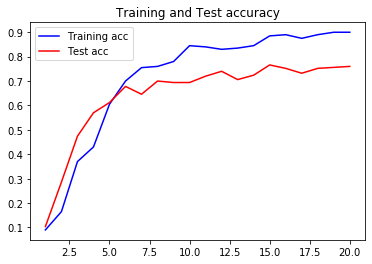

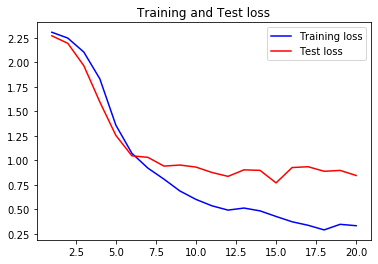

In [57]:
acc = history1['acc']
val_acc = history1['val_acc']
loss = history1['loss']
val_loss = history1['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.legend()
plt.show()

## TRAINABLE CIRCUIT

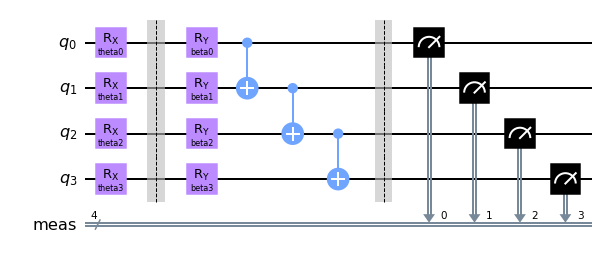

In [58]:
class QuanvCircuit:
    """ 
    This class defines filter circuit of Quanvolution layer
    """
    
    def __init__(self, kernel_size, backend, par, result = dict()):
        # --- Circuit definition start ---
        
        self.n_qubits = kernel_size ** 2
        all_qubits = [i for i in range(self.n_qubits)]
        self._circuit = qiskit.QuantumCircuit(self.n_qubits)
        self.theta = [qiskit.circuit.Parameter('theta{}'.format(i)) for i in range(self.n_qubits)]
        self.beta = [qiskit.circuit.Parameter('beta{}'.format(i)) for i in range(self.n_qubits)]
        self.par = par
        for i in range(self.n_qubits):
            self._circuit.rx(self.theta[i], i)

        self._circuit.barrier()

        for i in range(self.n_qubits):
            self._circuit.ry(self.beta[i], i)
        for k in range(self.n_qubits-1):
            self._circuit.cx(k, k+1)
            
        self._circuit = transpile(self._circuit, backend)
        self._circuit.measure_all()
        
        # ---- Circuit definition end ----

        self.backend   = backend
        self.result = result
    
    def update(self, par):
        L = [[a*np.pi,b*np.pi,c*np.pi,d*np.pi] for a in range(2) for b in range(2) for c in range(2) for d in range(2)]
        t = dict()
        for l in L:
            dic_theta = {self.theta[i]: theta for i,theta in zip(range(len(l)), l)}
            v = list(par)
            dic_beta = {self.beta[i]: beta for i,beta in zip(range(len(v)), v)}
            dic_fusion = dict((key, value) for d in (dic_theta, dic_beta) for key, value in d.items())
            para = [dic_fusion]
            qobj = assemble(self._circuit, shots=100, parameter_binds = para)
            job = self.backend.run(qobj)
            result = job.result()
            counts = result.get_counts()
            i=np.argmax(list(counts.values()))
            t[str(l)] = sum([int(m) for m in list(counts.keys())[i]])
        self.result = t  
        return self
    
    def copy(self):
        q = QuanvCircuit(int(np.sqrt(self.n_qubits)), self.backend, self.par.clone(), self.result)
        return q
    
    
    def encoding(self, zone):
        thetas = []
        for pixel in zone[0]:
            if pixel.item() > 0.5:
                thetas.append(np.pi) # etat |1>, on initialise theta à pi                      
            else:                    # pour faire une rotation d'angle pi de l'etat |0>
                thetas.append(0.0)     # etat |0>, on initialise theta à 0 (rester à l'etat |0>)
        return thetas


    def run(self, zone):
        zone = torch.reshape(zone, (1, self.n_qubits))
        init = str(self.encoding(zone))
        result = self.result[init]
        return result
circuit = QuanvCircuit(2, Aer.get_backend('qasm_simulator'),[]) 
circuit._circuit.draw(output='mpl')


In [59]:
def execute(inputs, quantum_circuits, width, length, l, kernel_size):
    outputs = torch.zeros((len(inputs), len(quantum_circuits), width, length))
    for i in range(len(inputs)):
        input = inputs[i]
        for c in range(len(quantum_circuits)):
#             print(quantum_circuits[c].result)
            circuit = (quantum_circuits[c]).copy()
            circuit = circuit.update(l)
#             print(circuit.result)
            for h in range(length):
                for w in range(width):
                    data = input[0, h:h+kernel_size, w:w+kernel_size]
                    outputs[i, c, h, w] = circuit.run(data)
    return outputs

class QuanvFunction(Function):
    """ Quanv function definition """
    @staticmethod
    def forward(ctx, inputs, params, kernel_size, quantum_circuits, shift):
        """ Forward pass computation """
        ctx.kernel_size      = kernel_size
        ctx.quantum_circuits = quantum_circuits
        ctx.shift            = shift
        l = params
        l = [l[i].item() for i in range(len(list(l)))]
        for c in range(len(quantum_circuits)):
            ctx.quantum_circuits[c].update(l)
        
        width, length = inputs[0][0].size()
        width = width - kernel_size + 1
        length = length - kernel_size + 1
        outputs = torch.zeros((len(inputs), len(quantum_circuits), width, length))
        for i in range(len(inputs)):
            input = inputs[i]
            for c in range(len(quantum_circuits)):
                circuit = quantum_circuits[c]
                for h in range(length):
                    for w in range(width):
                        data = input[0, h:h+kernel_size, w:w+kernel_size]
                        outputs[i, c, h, w] = circuit.run(data)
        ctx.save_for_backward(inputs, params)
        return outputs
    
    @staticmethod
    def backward(ctx, grad_output):
        inputs, params = ctx.saved_tensors
        g = grad_output.reshape(1, -1)
#         inputs = torch.reshape(inputs, (10, 28,28))
        grb = torch.Tensor()
        l = [list(params)[i].item() for i in range(len(list(params)))]
#         print("ok")
        for k in range(len(l)):
            shift_right = l.copy()
            shift_right[k] += np.pi/4
            shift_left = l.copy()
            shift_left[k]  -= np.pi/4
            expectation_right = execute(inputs, ctx.quantum_circuits, 27, 27, shift_right, ctx.kernel_size)
#             print('l')
            expectation_left = execute(inputs, ctx.quantum_circuits, 27, 27, shift_left, ctx.kernel_size)
            gradient = (expectation_right - expectation_left).reshape(-1, 1)
            grb = torch.cat((grb, (g.float() @ gradient.float()).reshape(1)))
        return None, grb, None, None, None
    

class Quanv(nn.Module):
    """ Quanvolution(Quantum convolution) layer definition """
    
    def __init__(self, nb_filters, kernel_size, backend =qiskit.Aer.get_backend('aer_simulator'), shift=np.pi/2):
        super(Quanv, self).__init__()
        self.par = nn.Parameter(torch.randn(4), requires_grad=True)
        self.quantum_circuits = [QuanvCircuit(kernel_size=kernel_size, backend=backend, par=self.par) for i in range(nb_filters)]
        self.kernel_size  = kernel_size
        self.shift        = shift
        
        
    def forward(self, inputs):
        return QuanvFunction.apply(inputs, self.par, self.kernel_size, self.quantum_circuits, self.shift)

In [60]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.quanv = Quanv(nb_filters=1, kernel_size = 2) 
        self.conv = nn.Conv2d(1, 10, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(160, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.quanv(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)
model = Net()
optimizer  = optim.Adam(model.parameters(), lr=0.001)
loss_fn  = nn.CrossEntropyLoss()

## TRAINING & PERFORMANCE

In [61]:
history = train(
    model = model,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_dl = train_loader,
    val_dl = test_loader,
    epochs=20)

train() called: model=Net, opt=Adam(lr=0.001000), epochs=20, device=cpu

Epoch   1/ 20, train loss:  2.34, train acc:  0.15, val loss:  2.22, val acc:  0.22
Epoch   2/ 20, train loss:  2.15, train acc:  0.23, val loss:  2.07, val acc:  0.43
Epoch   3/ 20, train loss:  2.00, train acc:  0.33, val loss:  1.86, val acc:  0.50
Epoch   4/ 20, train loss:  1.61, train acc:  0.55, val loss:  1.59, val acc:  0.53
Epoch   5/ 20, train loss:  1.30, train acc:  0.61, val loss:  1.32, val acc:  0.59
Epoch   6/ 20, train loss:  1.16, train acc:  0.67, val loss:  1.22, val acc:  0.59
Epoch   7/ 20, train loss:  0.92, train acc:  0.75, val loss:  1.14, val acc:  0.62
Epoch   8/ 20, train loss:  0.88, train acc:  0.72, val loss:  1.08, val acc:  0.64
Epoch   9/ 20, train loss:  0.72, train acc:  0.80, val loss:  1.04, val acc:  0.63
Epoch  10/ 20, train loss:  0.71, train acc:  0.81, val loss:  1.11, val acc:  0.65
Epoch  11/ 20, train loss:  0.57, train acc:  0.85, val loss:  1.14, val acc:  0.65
Epo

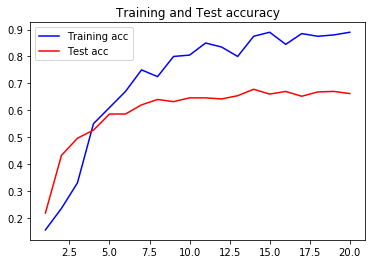

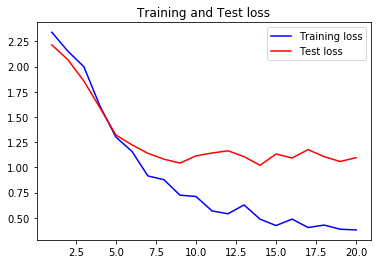

In [62]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.legend()
plt.show()

## CLASSICAL FILTER vs QUANTUM FILTER

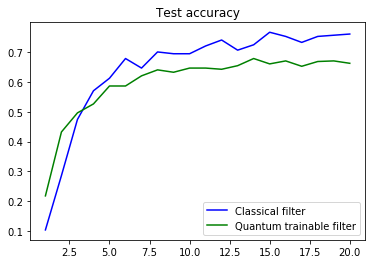

In [64]:
import matplotlib.pyplot as plt

acc1 = history1['val_acc']
acc2 = history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc1, 'b', label='Classical filter')
plt.plot(epochs, acc2, 'g', label='Quantum trainable filter')
plt.title('Test accuracy')
plt.legend()
plt.show()